In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')







In [23]:
from helper_functions import set_seeds

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Monkeypox','Others']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
!pip install torchinfo

In [26]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
!unzip /content/datasetMPOX.zip -d /content/dataset

Archive:  /content/datasetMPOX.zip
   creating: /content/dataset/datasetMPOX/
   creating: /content/dataset/datasetMPOX/Test/
   creating: /content/dataset/datasetMPOX/Test/Monkeypox/
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M04_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M19_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M19_02.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M23_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M38_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M38_02.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M39_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M39_02.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M40_01.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M40_02.jpg  
  inflating: /content/dataset/datasetMPOX/Test/Monkeypox/M40_03.jpg  
  inflating: /content/dataset/datasetMPOX/Test

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [27]:
# Setup directory paths to train and test images
train_dir = '/content/dataset/datasetMPOX/Train'
test_dir = '/content/dataset/datasetMPOX/Test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [28]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [29]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [39]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [55]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/going_modular/')


In [49]:
import engine
#from going_modular import engine


# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4435 | train_acc: 0.7966 | test_loss: 0.2316 | test_acc: 0.9615
Epoch: 2 | train_loss: 0.2835 | train_acc: 0.9005 | test_loss: 0.2411 | test_acc: 0.9231
Epoch: 3 | train_loss: 0.2240 | train_acc: 0.9361 | test_loss: 0.2307 | test_acc: 0.9231
Epoch: 4 | train_loss: 0.1905 | train_acc: 0.9449 | test_loss: 0.2080 | test_acc: 0.9231
Epoch: 5 | train_loss: 0.1650 | train_acc: 0.9528 | test_loss: 0.2102 | test_acc: 0.9231
Epoch: 6 | train_loss: 0.1516 | train_acc: 0.9562 | test_loss: 0.2792 | test_acc: 0.8690
Epoch: 7 | train_loss: 0.1350 | train_acc: 0.9617 | test_loss: 0.2271 | test_acc: 0.8846
Epoch: 8 | train_loss: 0.1258 | train_acc: 0.9660 | test_loss: 0.2384 | test_acc: 0.8846
Epoch: 9 | train_loss: 0.1155 | train_acc: 0.9701 | test_loss: 0.2782 | test_acc: 0.8690
Epoch: 10 | train_loss: 0.1081 | train_acc: 0.9729 | test_loss: 0.2577 | test_acc: 0.8846


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


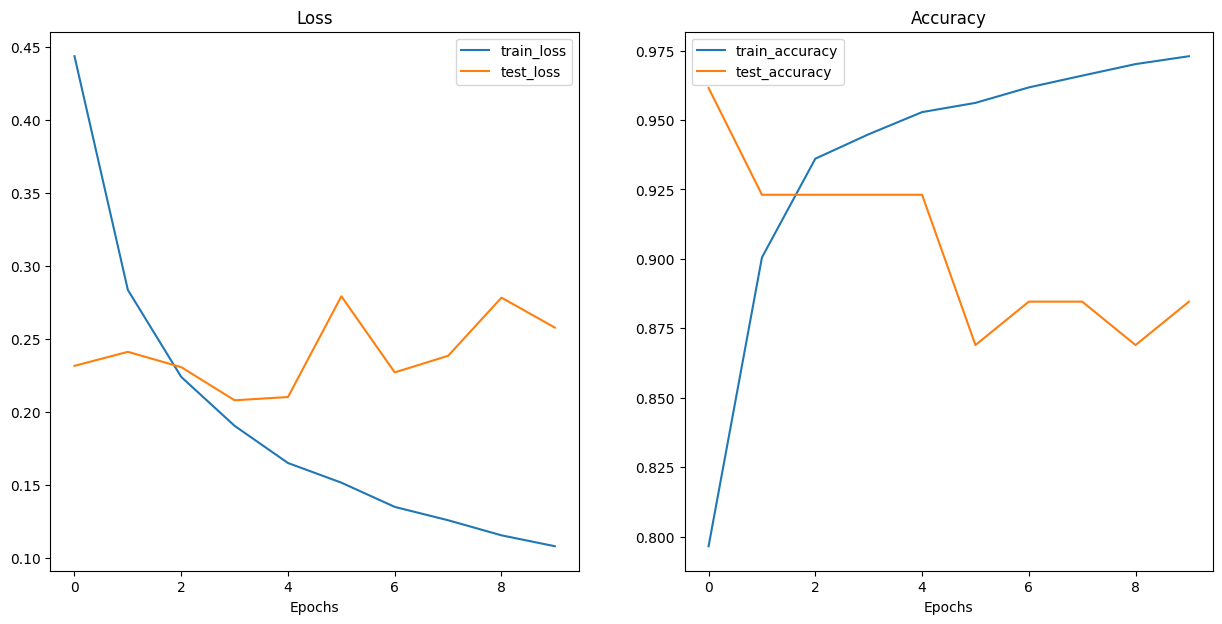

In [50]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

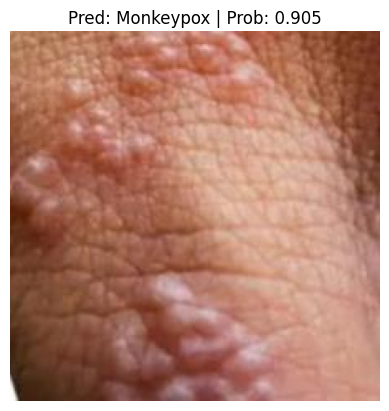

In [62]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/dataset/datasetMPOX/Test/Monkeypox/M19_02.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

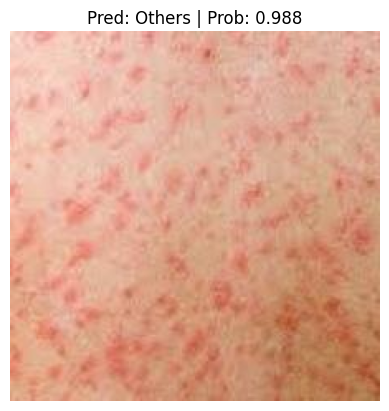

In [63]:
# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/dataset/datasetMPOX/Test/Others/NM12_01.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)